<a href="https://colab.research.google.com/github/kadireker/RNN_LSTM/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

StopWords

In [ ]:
WPT = nltk.WordPunctTokenizer()
stopwordlist = nltk.corpus.stopwords.words('turkish')
stopwordlist

In [ ]:
import random as r
dataset = pd.read_excel('/content/drive/MyDrive/TurkishTweets.xlsx' )
dataset.Tweet= dataset.Tweet.apply(str)
dataset
type(dataset)

pandas.core.frame.DataFrame

In [ ]:
dataset

In [ ]:
dataset.info()

Remove Duplicate

In [ ]:
dataset.Etiket.value_counts()

In [ ]:
dataset.Tweet.duplicated(keep="first").value_counts()

In [ ]:
dataset.drop_duplicates(subset="Tweet",keep="first",inplace=True,ignore_index=True)
dataset.describe()

PreProcessing

In [ ]:
# Noktalama işaretlerinin temizlenmesi
dataset['Tweet'] =dataset['Tweet'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))

#Büyük harflerin küçük harflere çevrilmesi
dataset['Tweet'] =dataset['Tweet'].apply(lambda x: x.lower())

#Fazladan bulunan boşlukların temizlenmesi
dataset['Tweet'] =dataset['Tweet'].apply(lambda x: x.strip())


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Verisetinde bulunan cümlelerdeki etkisiz kelimelerin kaldırılması
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in stopwordlist]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: token(x))

In [ ]:
dataset['Tweet']

0       allah'ım çıldıracağım yemin ederim çıldıracağı...
1       site zaman çalıştıda ürün stokları bitti diyor...
2                    sebebi neydi bağıracağım şimdi kaldı
3       black friday amk yıl çıkardınız bokuda mal mıs...
4       kısa kısa cevaplar vericeksen yazıyorsun geriz...
                              ...                        
3925                      aynı şeyleri yapmaktan sıkıldım
3926    olacağı varsa oluyor hani biteceği varsa bitsi...
3927                      istiyorum sonu fiyasko mutsuzum
3928        garip bir şekilde canım yanıyor moralim bozuk
3929    üzgünüm birazdan takipten çıkarıp hesabımı giz...
Name: Tweet, Length: 3930, dtype: object

In [ ]:
tweet = dataset['Tweet'].values.tolist()
sentiment = dataset['Etiket'].values.tolist()
for n, i in enumerate(sentiment):
  if i == "kızgın":
    sentiment[n]=0
  if i == "korku":
    sentiment[n]=1
  if i == "mutlu":
    sentiment[n]=2
  if i == "surpriz":
    sentiment[n]=3
  if i == "üzgün":
    sentiment[n]=4 
x_train, x_test, y_train, y_test = train_test_split(tweet,sentiment,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
sentiment

In [ ]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(tweet)
tokenizer.word_index

In [ ]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)

In [ ]:
max_tokens

14

In [ ]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9402035623409669

In [ ]:
x_train_padding = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_padding = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [ ]:
x_train_padding[15]

array([   0,    0,    0,    0, 7848, 7849,  516, 7850,  243,  410,   49,
        560, 7851,   30], dtype=int32)

In [ ]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

#LSTM

In [ ]:

model = Sequential()
embedding_dim = 100
model.add(Embedding(input_dim=10000,
                    output_dim=embedding_dim,
                    input_length=max_tokens,
                    name='embedding_layer'))

model.add(LSTM(units=32, return_sequences=True, dropout=0.4,
               recurrent_dropout=0.2, ))

model.add(LSTM(units=16, return_sequences=True, dropout=0.4,
               recurrent_dropout=0.2))

model.add(LSTM(units=8, dropout=0.4, recurrent_dropout=0.4, ))


model.add(Dense(5, activation='softmax'))


optimizer = Adam(lr=1e-3)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:

history = model.fit(x_train_padding, y_train,validation_split=0.25, epochs=10,
                    batch_size=8)

Epoch 1/10
295/295 [==============================] - 38s 67ms/step - loss: 1.5787 - accuracy: 0.2667 - val_loss: 1.1611 - val_accuracy: 0.5712
Epoch 2/10
295/295 [==============================] - 17s 58ms/step - loss: 0.8623 - accuracy: 0.7045 - val_loss: 0.6959 - val_accuracy: 0.7646
Epoch 3/10
295/295 [==============================] - 17s 59ms/step - loss: 0.3972 - accuracy: 0.8993 - val_loss: 0.6485 - val_accuracy: 0.7799
Epoch 4/10
295/295 [==============================] - 17s 57ms/step - loss: 0.2233 - accuracy: 0.9586 - val_loss: 0.5745 - val_accuracy: 0.8066
Epoch 5/10
295/295 [==============================] - 17s 58ms/step - loss: 0.1099 - accuracy: 0.9904 - val_loss: 0.6210 - val_accuracy: 0.7952
Epoch 6/10
295/295 [==============================] - 17s 58ms/step - loss: 0.0795 - accuracy: 0.9910 - val_loss: 0.6977 - val_accuracy: 0.7824
Epoch 7/10
295/295 [==============================] - 17s 58ms/step - loss: 0.0493 - accuracy: 0.9968 - val_loss: 0.6467 - val_accuracy:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Flatten, LSTM
from keras.layers.embeddings import Embedding

#GRU

In [ ]:
model2 = Sequential()
embedding_dim = 100
model2.add(Embedding(input_dim=10000,
                    output_dim=embedding_dim,
                    input_length=max_tokens,
                    name='embedding_layer'))

model2.add(GRU(units=32, return_sequences=True, dropout=0.4,
               recurrent_dropout=0.2, ))


model2.add(GRU(units=8, dropout=0.4 ))


model2.add(Dense(5, activation='softmax'))


optimizer = Adam(lr=1e-3)

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
y_train=np.array(y_train)

In [ ]:

history2 = model2.fit(x_train_padding, y_train,validation_split=0.25, epochs=10,
                    batch_size=8)

Epoch 1/10
295/295 [==============================] - 21s 43ms/step - loss: 1.4823 - accuracy: 0.3569 - val_loss: 0.5538 - val_accuracy: 0.8664
Epoch 2/10
295/295 [==============================] - 11s 38ms/step - loss: 0.3142 - accuracy: 0.9330 - val_loss: 0.2540 - val_accuracy: 0.9288
Epoch 3/10
295/295 [==============================] - 11s 37ms/step - loss: 0.0680 - accuracy: 0.9937 - val_loss: 0.2094 - val_accuracy: 0.9453
Epoch 4/10
295/295 [==============================] - 11s 36ms/step - loss: 0.0312 - accuracy: 0.9993 - val_loss: 0.1943 - val_accuracy: 0.9478
Epoch 5/10
295/295 [==============================] - 11s 36ms/step - loss: 0.0188 - accuracy: 0.9994 - val_loss: 0.1883 - val_accuracy: 0.9504
Epoch 6/10
295/295 [==============================] - 11s 37ms/step - loss: 0.0127 - accuracy: 0.9999 - val_loss: 0.1981 - val_accuracy: 0.9466
Epoch 7/10
295/295 [==============================] - 11s 36ms/step - loss: 0.0106 - accuracy: 0.9997 - val_loss: 0.2214 - val_accuracy:

In [ ]:
model.save("sentiment_modelson2.h5")


In [ ]:
model.load('/content/sentiment_modelson.h5', )

In [ ]:
y_test=np.array(y_test)

In [ ]:
result = model2.evaluate(x_test_padding, y_test)

25/25 [==============================] - 0s 5ms/step - loss: 0.1856 - accuracy: 0.9491


#BiLSTM

In [ ]:
from keras.models import Sequential
from keras import layers

from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras import regularizers
from keras import backend as K


In [ ]:
model1 = Sequential()
embedding_dim = 128
model1.add( Embedding(10000, input_length = max_tokens, output_dim=embedding_dim, ))
model1.add( Bidirectional( LSTM( units= 196, dropout = 0.2 )))
model1.add( Dense(5, activation = 'softmax'))

model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [ ]:
model1.fit(x_train_padding, y_train, epochs= 10, batch_size = 8,  validation_split=0.25)

Epoch 1/10
295/295 [==============================] - 33s 93ms/step - loss: 1.3178 - accuracy: 0.4328 - val_loss: 0.2011 - val_accuracy: 0.9351
Epoch 2/10
295/295 [==============================] - 25s 85ms/step - loss: 0.0810 - accuracy: 0.9778 - val_loss: 0.1883 - val_accuracy: 0.9389
Epoch 3/10
295/295 [==============================] - 25s 85ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.1930 - val_accuracy: 0.9453
Epoch 4/10
295/295 [==============================] - 25s 85ms/step - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.1741 - val_accuracy: 0.9504
Epoch 5/10
295/295 [==============================] - 25s 85ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.2174 - val_accuracy: 0.9389
Epoch 6/10
295/295 [==============================] - 24s 82ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.2961 - val_accuracy: 0.9224
Epoch 7/10
295/295 [==============================] - 24s 82ms/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.2071 - val_accuracy:

In [ ]:
y_test=np.array(y_test)

In [ ]:
result = model1.evaluate(x_test_padding, y_test)

25/25 [==============================] - 2s 64ms/step - loss: 0.2029 - accuracy: 0.9427


#TEST

In [ ]:
text = "Nasıl özledim bir bilse, ah bir bilseniz "
texts = [text]
tokens = tokenizer.texts_to_sequences(texts)
tokens_padding = pad_sequences(tokens,maxlen = max_tokens)
tokens_padding.shape
predict_result=model2.predict_classes(tokens_padding)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def result_string(x):
    return {
         0 : "Spnuç = kızgın - Cümle = " + text,
         1 : "Sonuç = korku - Cümle = " + text,
         2 : "Sonuç = mutlu - Cümle = " + text,
         3 : "Sonuç = surpriz - Cümle = " + text,
         4 : "Sonuç = üzgün - Cümle = "+ text
    }[x]
   

In [ ]:
print(result_string(predict_result[0]))

Sonuç = korku - Cümle = Nasıl özledim bir bilse, ah bir bilseniz 


Sonuç = üzgün - Cümle = En sevdiğim bardağım kırıldığı için ağladım.


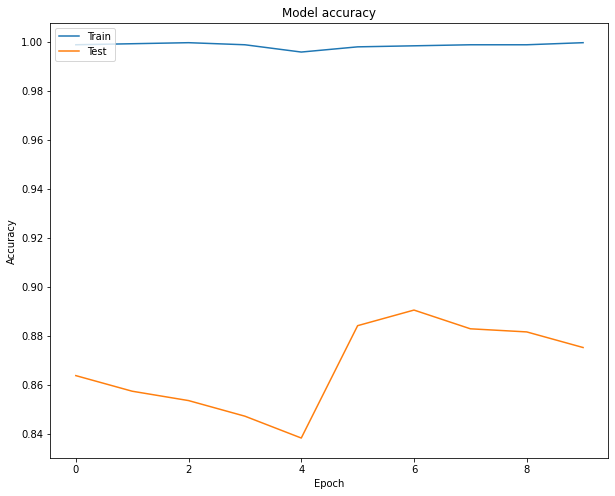

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validation_and_test, y_train, y_validation_and_test =train_test_split(tweet,sentiment, test_size = .02,random_state = 42)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.1, random_state=SEED)

In [ ]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 21.2 ms


In [ ]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],columns=['predicted_positive','predicted_negative'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 30.99%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                  22                   0
negative                  10                   0
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.31      1.00      0.47        22
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        12

    accuracy                           0.31        71
   macro avg       0.06      0.20      0.09        71
weighted avg       0.10      0.31      0.15        71



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
